In [1]:
# Import all necessary libraries
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from dreams.utils.data import CSRKNN, condense_dreams_knn
from dreams.utils.io import setup_logger
import dreams.utils.mols as mu
from dreams.utils.plots import init_plotting, save_fig, get_nature_hex_colors
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.data import MSData
from dreams.algorithms.lsh import BatchedPeakListRandomProjection
from dreams.definitions import *
%reload_ext autoreload
%autoreload 2

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


### Load data

In [2]:
in_pth = Path('../../data/MassSpecGym_DreaMS.hdf5')
msdata = MSData.load(in_pth, in_mem=True)
msdata.get_spectra().shape

Loading dataset MassSpecGym_DreaMS into memory (213548 spectra)...


(213548, 2, 128)

In [3]:
# Choose spectra with > 3 peaks having intensity > 10%
mask = (msdata.get_spectra()[:, 1, :] > 0.1).sum(axis=1) > 3
# Choose spectra with adduct [M+H]+ only
mask &= msdata.get_adducts() == '[M+H]+'
# Subset the data
idx_subset = np.where(mask)[0]
specs, prec_mzs, smiles = msdata.get_spectra(idx_subset), msdata.get_prec_mzs(idx_subset), msdata.get_smiles(idx_subset)
inchi_keys = np.array([mu.smiles_to_inchi14(s) for s in tqdm(smiles)])

100%|██████████| 94837/94837 [00:23<00:00, 4037.67it/s]


### Benchmark LSH approximation of cos. similarity and influence of LSH parameters

In [30]:
print(f'Estimating cosine similarities on the subset of {specs.shape[0]} spectra with > 3 peaks having intensity > 10%.')
cos_sim = PeakListModifiedCosine()

res = []
for bin_step in [0.1, 0.5, 1]:
    for n_hyperplanes in [20, 30, 50, 70, 100, 150, 250]:

        # Compute LSHs
        t1 = time.time()
        lsh_projector = BatchedPeakListRandomProjection(bin_step=bin_step, n_hyperplanes=n_hyperplanes)
        lshs = lsh_projector.compute(specs)
        t = time.time() - t1

        # Sample at most 1000 clusters with 5-100 spectra
        lshs_vc = pd.Series(lshs).value_counts()
        lshs_sample = lshs[(lshs_vc[lshs] >= 5) & (lshs_vc[lshs] <= 100)]
        if lshs_sample.shape[0] > 1000:
            lshs_sample = lshs_sample[np.random.choice(lshs_sample.shape[0], 1000, replace=False)]

        # Compute statistics
        res.append({
            'M/z bin width': bin_step,
            'Num. hyperplanes': n_hyperplanes,
            'Dataset size [%]': len(lshs_vc) / len(idx_subset) * 100,
            'Mean intra-cluster mod. cosine similarity': np.mean([
                cos_sim.compute_pairwise(
                    specs=specs[np.where(lshs == lsh_i)[0]],
                    prec_mzs=prec_mzs[np.where(lshs == lsh_i)[0]]
                ) for lsh_i in tqdm(lshs_sample, desc='Computing intra-cluster similarities')
            ]),
            'Precursor m/z std. dev. per cluster': np.mean([
                np.std(prec_mzs[np.where(lshs == lsh_i)[0]]) for lsh_i in lshs_sample
            ]),
            'LSH computation time [s]': t
        })
res = pd.DataFrame(res)
res

Estimating cosine similarities on the subset of 94837 spectra with > 3 peaks having intensity > 10%.


Computing LSHs: 100%|██████████| 94837/94837 [02:04<00:00, 759.15it/s]
/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_15939/748678826.py:15: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  lshs_vc = pd.Series(lshs).value_counts()
Computing LSHs: 100%|██████████| 94837/94837 [02:10<00:00, 724.95it/s]
/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_15939/748678826.py:15: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  lshs_vc = pd.Series(lshs).value_counts()
Computing LSHs: 100%|██████████| 94837/94837 [02:22<00:00, 665.72it/s]
/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykerne

,M/z bin width,Num. hyperplanes,Dataset size [%],Mean intra-cluster mod. cosine similarity,Precursor m/z std. dev. per cluster,LSH computation time [s]
0,0.1,20,52.230669,0.867670,49.996575,124.932127
1,0.1,30,65.483936,0.973208,18.990317,130.827512
2,0.1,50,73.012643,0.993328,5.787081,142.468606
3,0.1,70,76.223415,0.996309,2.882601,154.503999
4,0.1,100,78.996594,0.998514,1.323353,172.908518
5,0.1,150,81.635859,0.999355,0.587395,203.086081
6,0.1,250,84.182334,0.999784,0.087094,261.922371
7,0.5,20,50.255702,0.842959,49.397148,24.769938
8,0.5,30,65.068486,0.965809,19.998459,25.638983
9,0.5,50,72.824952,0.992518,6.053841,27.995290


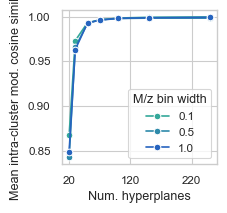

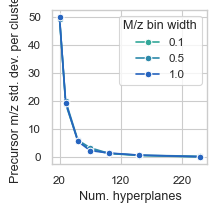

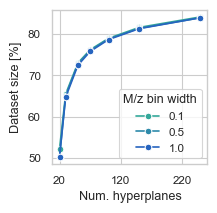

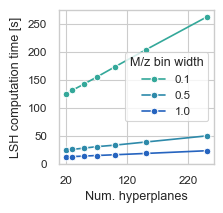

In [39]:
init_plotting(figsize=(2, 2))
for col in [
    'Mean intra-cluster mod. cosine similarity',
    'Precursor m/z std. dev. per cluster',
    'Dataset size [%]',
    'LSH computation time [s]'
]:
    sns.lineplot(
        data=res, y=col, x='Num. hyperplanes', hue='M/z bin width', marker='o',
        palette=sns.blend_palette(reversed(get_nature_hex_colors()[:2]), as_cmap=True)
    )
    plt.xticks([20, 120, 220])
    save_fig(f'lsh_hyperplanes_{col.replace(" ", "_").replace(".", "").replace("/", "")}.svg')
    plt.show()

### Benchmark LSH clustering wrt InChI precision and recall

In [49]:
lsh_projector = BatchedPeakListRandomProjection(bin_step=1, n_hyperplanes=30)
lshs = lsh_projector.compute(specs)

Computing LSHs: 100%|██████████| 94837/94837 [00:12<00:00, 7309.24it/s]


In [9]:
from sklearn.metrics import precision_score, recall_score
from pandarallel import pandarallel

def compute_precision_recall(i, pred_clusters):
    y_pred = pred_clusters == pred_clusters[i]
    if y_pred.sum() < 2:
        return None, None
    # y_true = np.array([mu.morgan_smiles_sim(smiles[i], smiles[j]) > 0.9 for j in range(len(smiles))])
    y_true = inchi_keys == inchi_keys[i]
    if y_true.sum() < 2:
        return None, None
    y_pred, y_true = np.delete(y_pred, i), np.delete(y_true, i)
    return precision_score(y_true, y_pred), recall_score(y_true, y_pred)

compute_precision_recall(121, lshs)

(1.0, 0.14285714285714285)

In [10]:
# Sample 10000 random spectra
random.seed(42)
df = pd.DataFrame({'i': random.sample(range(len(lshs)), 10000)})
df['lsh'] = lshs[df['i'].tolist()]

# Compute precision and recall
pandarallel.initialize(progress_bar=True, nb_workers=8)
df[['Precision', 'Recall']] = df.parallel_apply(lambda row: compute_precision_recall(row['i'], lshs), axis=1, result_type='expand')
df['method'] = 'LSH'
df = df.dropna()
display(df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,i,lsh,Precision,Recall,method
0,83810,b'9143c7117addec216ee2e0aa13be7c0e220ecca99215...,1.000000,0.214286,LSH
1,14592,b'0ed4e5a8640bc5d5a93229c75cde608cb9cd4553f4bd...,0.333333,0.021277,LSH
2,3278,b'0081a406a331aa71e49003bd1c3582ae60685647fd38...,1.000000,0.023529,LSH
3,36048,b'15aa9e2d467d336b8c01b0cf51d6d983725a6334f287...,1.000000,0.052632,LSH
4,32098,b'c297081308a0671a61619ad6b59b32760c32e0ee2736...,0.500000,0.014493,LSH
...,...,...,...,...,...
9993,47579,b'e642d4a2fed26ae4379b1a506bb248ab77b2fc38e907...,1.000000,0.013514,LSH
9994,4822,b'13a2f0a8cac3f2f2c1e094af55e32055cc6a9ec0663c...,1.000000,0.065217,LSH
9995,36799,b'c6c814a94520d5a8cb84a8f81ef26a688ea9cc5ea863...,1.000000,0.135802,LSH
9997,92663,b'101dd544b56e1bdda26f5317742b89bb10f5eb9eab73...,1.000000,0.666667,LSH


### Benchmark LSH + DreaMS k-NN aggregation

In [50]:
idx_unique = np.unique(lshs, return_index=True)[1]
print(f'Number of unique LSHs: {len(idx_unique)}')
n_clusters = {'LSH': len(idx_unique)}
embs = msdata.get_values(DREAMS_EMBEDDING)[idx_subset][idx_unique]
embs.shape

Number of unique LSHs: 61377


(61377, 1024)

In [51]:
# Construct k-NN graph
csr = kneighbors_graph(embs, n_neighbors=3, metric='cosine', mode='distance')
knn = CSRKNN(csr).to_igraph(directed=False)

Constructing graph edges: 100%|██████████| 61377/61377 [00:00<00:00, 273118.44it/s]


In [11]:
dfs = [df]
for thld in [0.9, 0.75, 0.6]:
    # Condense the k-NN graph with bfs neighborhood aggregation
    knn_clusters = condense_dreams_knn(graph=knn, thld=thld, embs=embs, logger=setup_logger())

    # Assign clusters to LSHs
    clusters = np.zeros(len(lshs)) - 1
    for i, cluster in tqdm(enumerate(knn_clusters)):
        for c in cluster:
            c_lsh_idx = np.where(lshs == lshs[idx_unique[c]])[0]
            clusters[c_lsh_idx] = i

    # Compute precision and recall
    df_ = df.copy()
    pandarallel.initialize(progress_bar=False, nb_workers=8)
    df_[['Precision', 'Recall']] = df_.parallel_apply(lambda row: compute_precision_recall(row['i'], clusters), axis=1, result_type='expand')
    method = f'LSH + k-NN (DreaMS > {thld})'
    df_['method'] = method
    n_clusters[method] = len(knn_clusters)
    df_ = df_.dropna()

    dfs.append(df_)
dfs = pd.concat(dfs)

2024-08-02 19:08:55,968 | INFO | Forming clusters:   0%|          | 0/61377 [00:00<?, ?it/s]


45260it [00:10, 4151.02it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
2024-08-02 19:09:29,775 | INFO | Forming clusters:   0%|          | 0/61377 [00:00<?, ?it/s]


26516it [00:10, 2490.52it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
2024-08-02 19:10:03,877 | INFO | Forming clusters:   0%|          | 0/61377 [00:00<?, ?it/s]


13146it [00:10, 1219.47it/s]


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [13]:
dfs_sizes = []
for k, v in n_clusters.items():
    dfs_sizes.append({
        'method': k,
        'value': v / len(lshs),
        'metric': 'Dataset size [%]'
    })
dfs_sizes = pd.DataFrame(dfs_sizes)
dfs_sizes

,method,value,metric
0,LSH,0.647184,Dataset size [%]
1,LSH + k-NN (DreaMS > 0.9),0.477240,Dataset size [%]
2,LSH + k-NN (DreaMS > 0.75),0.279596,Dataset size [%]
3,LSH + k-NN (DreaMS > 0.6),0.138617,Dataset size [%]


/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_14832/3779145731.py:4: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.barplot(


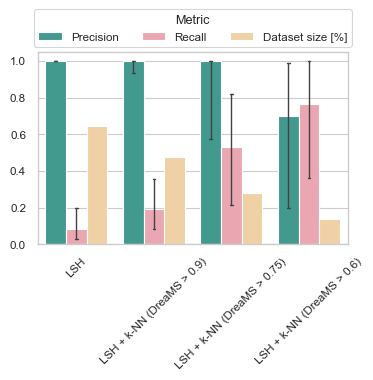

In [16]:
dfs_melt = dfs.melt(id_vars=['method'], value_vars=['Precision', 'Recall'], var_name='metric', value_name='value')
dfs_melt = pd.concat([dfs_melt, dfs_sizes])
init_plotting(figsize=(4, 2.5), cmap='nature')
sns.barplot(
    data=dfs_melt, y='value', x='method', hue='metric', estimator='median',
    errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)),
    capsize=0.1, err_kws={'linewidth': 1}, palette=get_nature_hex_colors()[1:]
)
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Metric', bbox_to_anchor=(0.5, 1.25), loc='upper center', ncols=3)
save_fig('atlas_clustering_eval.svg')
plt.show()

### Analyze clusters leading to precision < 1

In [92]:
dfs[(dfs['method'] == 'LSH + k-NN (DreaMS > 0.9)') & (dfs['Precision'] < 1)].sample(20)

,i,lsh,Precision,Recall,method
9429,27159,b'69d82f7a1d60eca6fe6be153dd545424c64c15e5fc25...,0.933333,0.222222,LSH + k-NN (DreaMS > 0.9)
2489,29824,b'd4edca2ad1c3c51eb517a30866252ae7a71db981e796...,0.833333,0.333333,LSH + k-NN (DreaMS > 0.9)
3372,94633,b'df0148872e755693a365337bfbf53ad6529d455b31f3...,0.191781,0.777778,LSH + k-NN (DreaMS > 0.9)
7961,1901,b'5ab5b932e436a8a8360ff4f5abfba59e248c9c65e2b3...,0.583333,0.218750,LSH + k-NN (DreaMS > 0.9)
4373,39171,b'9bcf9d87fd49da171bd670255d521617c48b75020af5...,0.310345,0.428571,LSH + k-NN (DreaMS > 0.9)
5118,8130,b'55ac7b336ba61e57f69729377786db05763f4c22cca5...,0.692308,0.346154,LSH + k-NN (DreaMS > 0.9)
8773,27912,b'2f669527dfc4f239f2f123c9f26c28571e3877c00841...,0.833333,0.333333,LSH + k-NN (DreaMS > 0.9)
9457,8344,b'df80a1d21e51590581e512bec49044cbc634e9144a26...,0.534759,0.421941,LSH + k-NN (DreaMS > 0.9)
743,70702,b'd0daae6dc7d26569015d002fe174398b597fab33284c...,0.600000,1.000000,LSH + k-NN (DreaMS > 0.9)
5077,38086,b'd6011725bba8ffa59af52357823540ee6d253c41c3da...,0.655172,0.487179,LSH + k-NN (DreaMS > 0.9)


In [52]:
thld = 0.9

# Condense the k-NN graph with bfs neighborhood aggregation
knn_clusters = condense_dreams_knn(graph=knn, thld=thld, embs=embs, logger=setup_logger())

# Assign clusters to LSHs
clusters = np.zeros(len(lshs)) - 1
for i, cluster in tqdm(enumerate(knn_clusters)):
    for c in cluster:
        c_lsh_idx = np.where(lshs == lshs[idx_unique[c]])[0]
        clusters[c_lsh_idx] = i

2024-08-03 18:18:14,514 | INFO | Forming clusters:   0%|          | 0/61377 [00:00<?, ?it/s]


45260it [00:11, 4042.53it/s]


GPTFURBXHJWNHR    28
HXCUIEYBVCYJPX     1
ZAALQOFZFANFTF     1
Name: count, dtype: int64


CN1CCC2=CC3=C(C=C2C(=O)CC4=C(C1)C5=C(C=C4)OCO5)OCO3    28
CN1CC2=CC3=C(C=C2CCC(=O)C4=CC5=C(C=C4C1)OCO5)OCO3       1
CN1CCC2=CC3=C(C=C2C(=O)CC4=CC5=C(C=C4C1)OCO5)OCO3       1
Name: count, dtype: int64


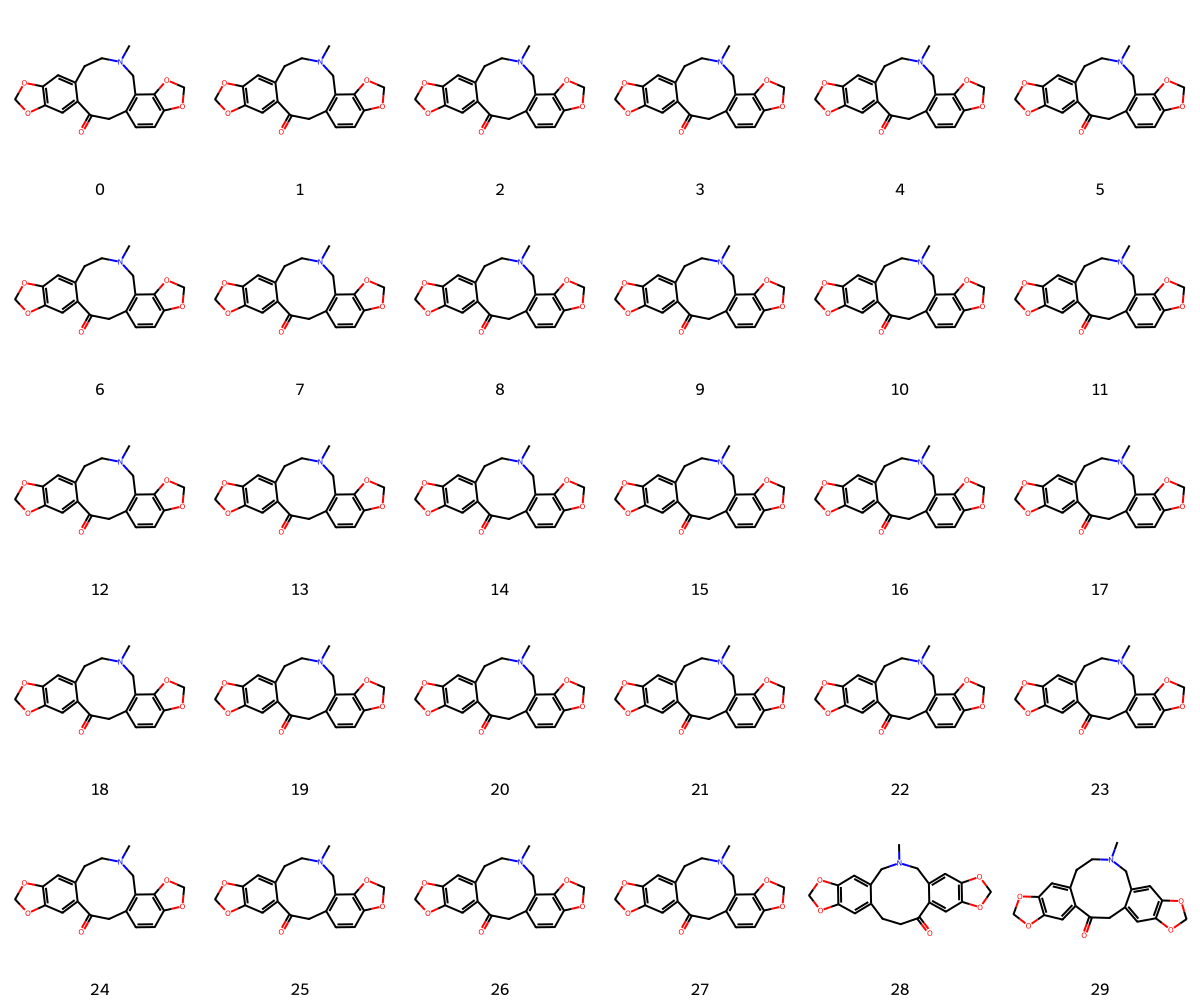

In [53]:
i = 39500
idx_cluster = np.where(clusters == clusters[i])[0]
print(pd.Series(inchi_keys[idx_cluster]).value_counts())
print(pd.Series(smiles[idx_cluster]).value_counts())
mu.show_mols(smiles[idx_cluster], smiles_in=True)#, save_pth=FIGURES / 'mols.svg', svg=True)

39464
prec_mzs: 354.1336
Mod. cos. similarity 0.9999999999999993


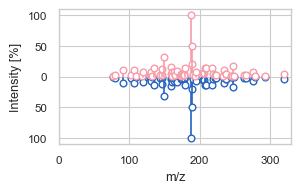

53307
prec_mzs: 354.1336059570312
Mod. cos. similarity 0.9805554189800487


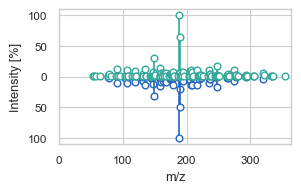

61911
prec_mzs: 354.1336
Mod. cos. similarity 0.8689445875429264


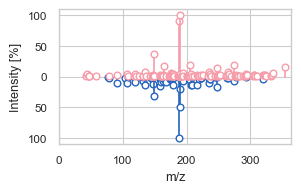

In [54]:
import msml.utils.spectra as su

cos_sim = PeakListModifiedCosine()
init_plotting(figsize=(2, 2), cmap='nature')

for o, i in enumerate(idx_cluster[[0, -2, -1]]):
    print(i)
    colors = get_nature_hex_colors()
    print('prec_mzs:', prec_mzs[i])
    print('Mod. cos. similarity', cos_sim(spec1=specs[i], prec_mz1=prec_mzs[i], spec2=specs[idx_cluster[0]], prec_mz2=prec_mzs[idx_cluster[0]]))
    su.plot_spectrum(
        specs[i], mirror_spec=specs[idx_cluster[0]], save_pth=FIGURES / f'clustering_mirror{i}.svg',
        colors=[colors[1 if o == 1 else 2], colors[3], colors[0]], figsize=(3, 1.75)
    )